In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import pickle
import miceforest as mf
warnings.filterwarnings("ignore")
import functools
from functools import reduce
from mc4.algorithm import mc4_aggregator
from copy import deepcopy

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from collections import Counter

import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch.utils.data import Dataset, DataLoader

In [2]:
rs = 42

In [3]:
import random

def _init_fn(worker_id):
    np.random.seed(int(rs))
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [4]:
# Undersample Test Set
test_under_sampler = 0
do_class_weight = 1

# Undersample Train Set
do_smote = 0
do_random_under_sampler = 0
do_random_over_sampler = 0
do_tomek_links = 0
do_near_miss = 0

In [5]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [6]:
os.chdir('..')

In [7]:
prediction_window = ""

In [8]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

In [9]:
model = 'Pytorch MLP'

In [10]:
model_directory = 'Sepsis Models/' + prediction_window + '/' + model + '/'

#### Loading Cleaned Data

In [11]:
def get_features_diag(data):
    features = list(data_dictionary[hosp])
    features.remove(list(data_dictionary[hosp])[-1])
    AKI_diag = list(data_dictionary[hosp])[-1]
    return features, AKI_diag

def do_training_modifications(X_train, y_train):
    if do_smote:
        oversample = SMOTE(random_state=rs)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    if do_random_under_sampler:
        rus = RandomUnderSampler(replacement=True, random_state=rs)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    if do_random_over_sampler:
        ros = RandomOverSampler(random_state=rs)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    if do_tomek_links:
        tl = TomekLinks(random_state=rs)
        X_train, y_train = tl.fit_resample(X_train, y_train)
    if do_near_miss:
        nm = NearMiss(random_state=rs)
        X_train, y_train = nm.fit_resample(X_train, y_train)  
    return X_train, y_train

def normalize_data(data_dictionary, hosp):
    df = deepcopy(data_dictionary[hosp])
    demographic_index = list(df).index('is_female')
    medical_signs = list(df)[:demographic_index]
    medication_index = list(df).index('ACETAMIN')
    medications = list(df)[medication_index:len(list(data))-1]
    demographic_binary = ['is_female', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery']
    binary_features = medications + demographic_binary
    continuous_features = medical_signs + ['age', 'BMI']

    df[continuous_features] = (df[continuous_features]-df[continuous_features].mean())/df[continuous_features].std()
    df[binary_features] = df[binary_features].replace([0],-1)
    return df

In [12]:
temp_data_dictionary = dict.fromkeys(hosps)
data_dictionary = dict.fromkeys(hosps)
missing_dictionary = dict.fromkeys(hosps)

In [13]:
for hosp in data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data_dictionary[hosp] = data
    
for hosp in temp_data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/unscaled/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    temp_data_dictionary[hosp] = data

In [14]:
for hosp in data_dictionary:
    data_dictionary[hosp] = normalize_data(data_dictionary, hosp)

### Model Architectures

In [15]:
class MLP(nn.Module):
    def __init__(self,input_shape):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_shape,10)
        self.fc2 = nn.Linear(10,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def fit(self, X_train, y_train, epochs=200, lr=0.001):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.train_model(train_loader, criterion, optimizer, epochs, class_weights)
        return self
    
    def predict_prob(self, X):
        with torch.no_grad():
            return np.array(self(torch.tensor(X,dtype=torch.float32)).flatten())
        
    def get_predictions(self, X_test):
        with torch.no_grad():
            predicted = self(torch.tensor(X_test,dtype=torch.float32))
            predictions_one_encoded = predicted.reshape(-1).detach().numpy().round()
            return np.array(predicted).flatten(), predictions_one_encoded
        
    def train_model(self, train_loader, criterion, optimizer, epochs, class_weights):
        for i in range(epochs):
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
    
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length    


In [16]:
class LR(nn.Module):
    def __init__(self,input_shape):
        super(LR,self).__init__()
        self.fc1 = nn.Linear(input_shape,1)
    
    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def fit(self, X_train, y_train, epochs=200, lr=0.01, batch_size=64):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.train_model(train_loader, criterion, optimizer, epochs, class_weights)
        return self
    
    def predict_prob(self, X):
        with torch.no_grad():
            return np.array(self(torch.tensor(X,dtype=torch.float32)).flatten())
        
    def get_predictions(self, X_test):
        with torch.no_grad():
            predicted = self(torch.tensor(X_test,dtype=torch.float32))
            predictions_one_encoded = predicted.reshape(-1).detach().numpy().round()
            return np.array(predicted).flatten(), predictions_one_encoded
        
    def train_model(self, train_loader, criterion, optimizer, epochs, class_weights):
        for i in range(epochs):
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

### Model Feature Importances

In [17]:
features, _ = get_features_diag(data)

In [18]:
unscaled_agg_data = pd.concat(temp_data_dictionary.values())
unscaled_agg_X = unscaled_agg_data[features]

### SHAP

In [19]:
filename = 'Sepsis Code/Feature Importances/' + model + '_Feat_Dicts.pckl'
information = pickle.load(open(filename, 'rb'))
local_shap_explainers, local_shap_values, local_X, explainer_agg, shap_values_agg = tuple(information)

#### Local Models

In [20]:
hosp_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

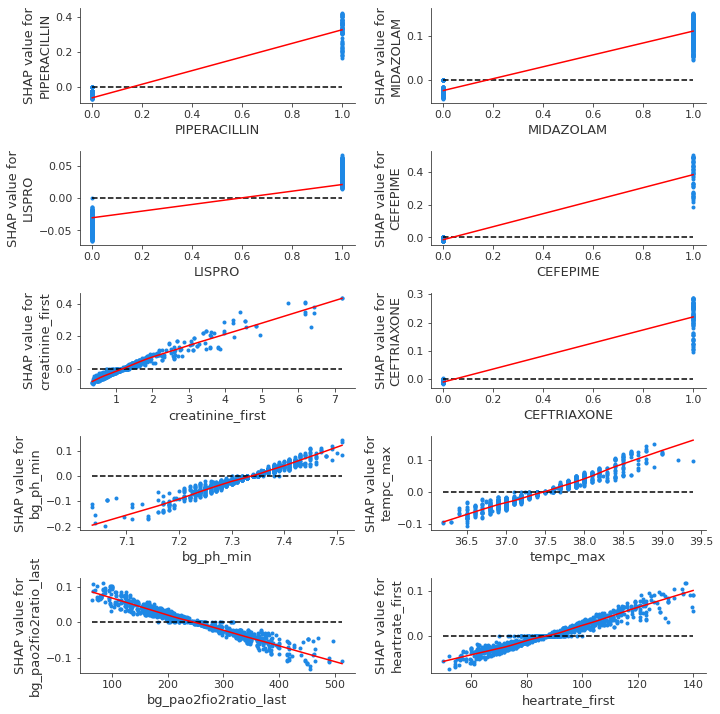

In [21]:
# Using One Specific Hospital
hosp = "420"
num_rows = 5
num_cols = 2
df_temp = pd.read_csv("Sepsis Code/Feature Importances/" + model + "_" + prediction_window + "_SHAPImportantFeatures.csv")
df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
top_features = (df_temp[hosp].values)[0:10]
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,10))
for i, feature in enumerate(top_features):
    idx = np.where(local_X[hosp].columns==feature)[0][0]
    unscaled_X = temp_data_dictionary[hosp][features]
    x = shap.sample(unscaled_X, 1000).iloc[:,idx]
    y_sv = local_shap_values[hosp][:,idx]
    lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
    ax = axes[divmod(i, num_cols)]
    ax.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linestyles='dashed', color='black')
    ax.plot(*list(zip(*lowess)), color="red", )
    shap.dependence_plot(feature, local_shap_values[hosp], shap.sample(unscaled_X, 1000), ax=ax, show=False,
                         interaction_index=None)
fig.tight_layout()

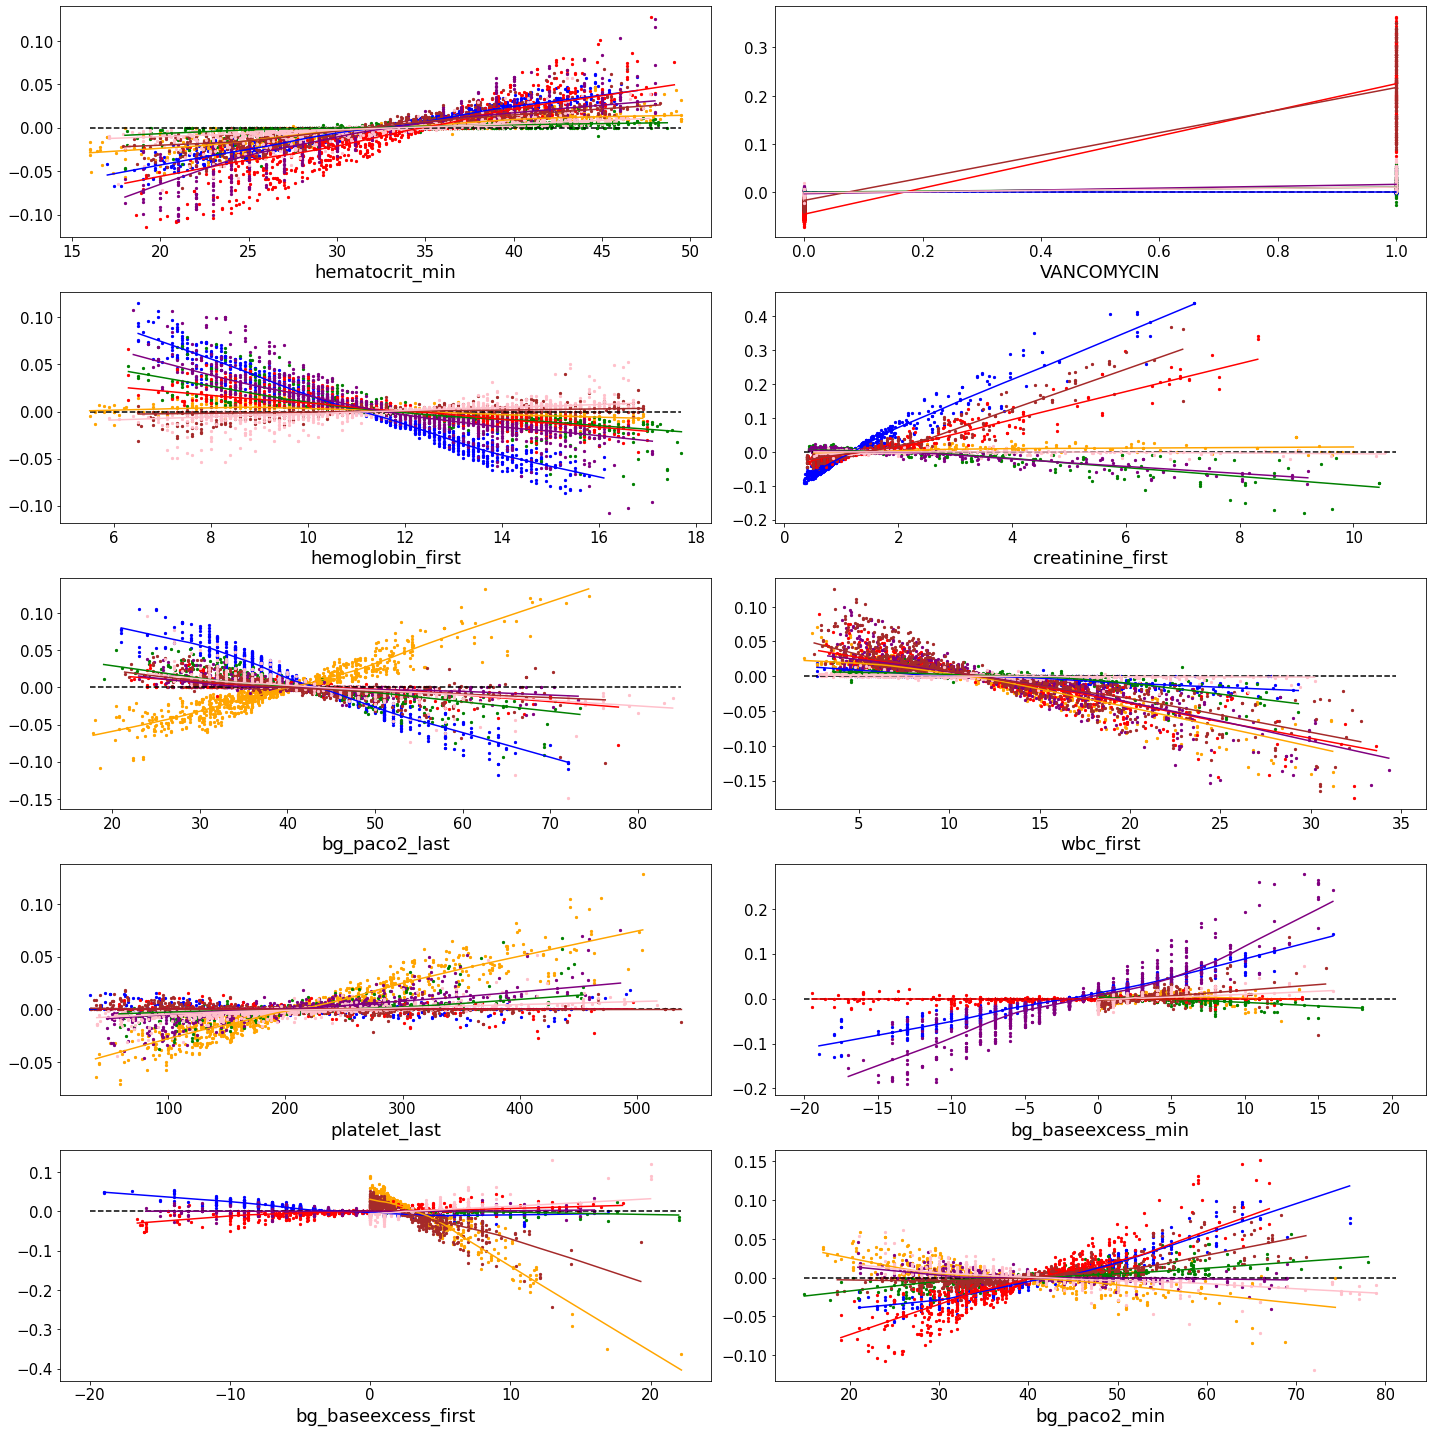

In [22]:
num_rows = 5
num_cols = 2
top_features = (df_temp['Agg'].values)[0:10]
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
for i, feature in enumerate(top_features):
    ax = axes[divmod(i, num_cols)]
    for j, hosp in enumerate(hosps):
        idx = np.where(local_X[hosp].columns==feature)[0][0]
        unscaled_X = temp_data_dictionary[hosp][features]
        x = shap.sample(unscaled_X, 1000).iloc[:,idx]
        y_sv = local_shap_values[hosp][:,idx]
        lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
        ax.plot(*list(zip(*lowess)), color=hosp_colors[j], )
        index_feature = list(unscaled_X).index(feature)
        feat_shap_values = local_shap_values[hosp][:, index_feature]
        feat_values = shap.sample(unscaled_X, 1000).values[:, index_feature]
        ax.scatter(x=feat_values, y=feat_shap_values, color=hosp_colors[j], s=5)
    ax.hlines(y=0, xmin=np.min(unscaled_agg_X[feature]), xmax=np.max(unscaled_agg_X[feature]), linestyles='dashed', color='black')
    ax.set_xlabel(feature, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()

#### Aggregated Model

In [23]:
agg_data = pd.concat(data_dictionary.values())
features, AKI_diag = get_features_diag(agg_data)
X = agg_data[features]

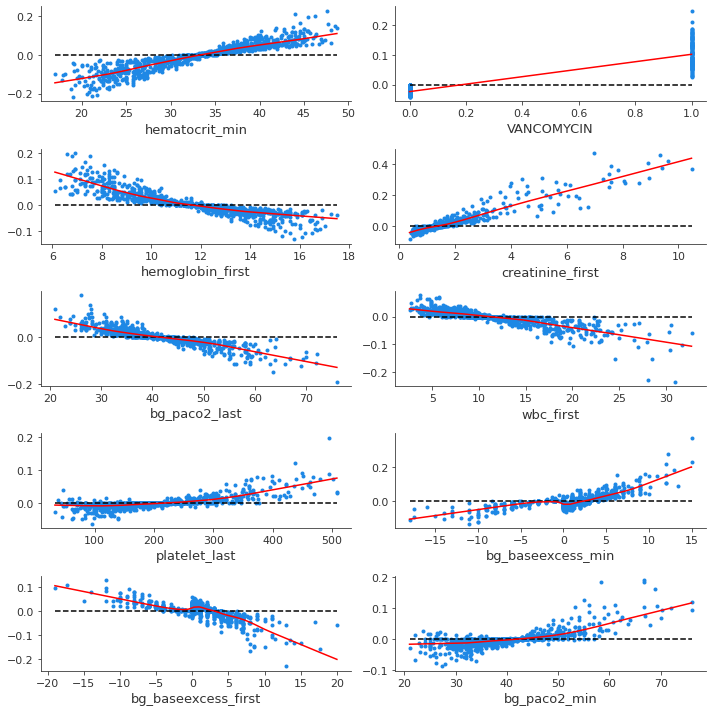

In [24]:
num_rows = 5
num_cols = 2
df_temp = pd.read_csv("Sepsis Code/Feature Importances/" + model + "_" + prediction_window + "_SHAPImportantFeatures.csv")
df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
top_features = (df_temp['Agg'].values)[0:10]
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10,10))
for i, feature in enumerate(top_features):
    idx = np.where(X.columns==feature)[0][0]
    unscaled_agg_data = pd.concat(temp_data_dictionary.values())
    unscaled_X = unscaled_agg_data[features]
    x = shap.sample(unscaled_X, 1000).iloc[:,idx]
    y_sv = shap_values_agg[:,idx]
    lowess = sm.nonparametric.lowess(y_sv, x, frac=.3)
    ax = axes[divmod(i, num_cols)]
    ax.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linestyles='dashed', color='black')
    ax.plot(*list(zip(*lowess)), color="red", )
    shap.dependence_plot(feature, shap_values_agg, shap.sample(unscaled_X, 1000), ax=ax, show=False,
                         interaction_index=None)
    ax.set(ylabel=None)
fig.tight_layout()